# Assignment 10.2 - Vision Model

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf.

#### Please state both names of your group members here:
Farah Ahmed Atef Abdelhameed Hafez

## Task 10.2.1: Pre-trained VGG-11 for Image Classification

First, we recommend using PyTorch for this assignment, a popular machine learning framework. Should be able to install it according to the official instructions on [pytorch.org](https://pytorch.org/).

It might be useful to use [Google Colab](https://colab.research.google.com), too. Google offers some compute, so you are not stuck running your programs locally. You can even use GPUs and TPUs! For this assignment, your local machine should be enough, though. In Google Colab variables might get lost when your computer disconnects from the internet or the notebook runs idle for a while.

Browse through the [pytorch tutorials ](https://pytorch.org/tutorials/), they often come as colab notebooks - go and execute some!

* Initialize and import the VGG-11 model using PyTorch. Use it for classifying at least 20 CIFAR10 Images, without training it from scratch. **(RESULT)**

Training for 1 epoch or a few iterations is totally fine, especially if you run it on cpu. Speed depends on your hardware. You can use Google Colab if you don't have a GPU available, to have a bit more compute.

Trained for few epochs

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10

from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load VGG11 with batch normalization (recommended)
vgg11 = models.vgg11_bn(pretrained=True)


# CIFAR-10 has 10 classes, but VGG was trained on ImageNet (1000 classes)
# Replace the final classifier layer
num_classes = 10

input_lastLayer = vgg11.classifier[6].in_features
vgg11.classifier[6] = nn.Linear(input_lastLayer,num_classes)
for param in vgg11.features.parameters():
    param.requires_grad = False

vgg11.to(device)

transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5 ))])

trainset = CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32,
                                            shuffle=True, num_workers=2)
testset = CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32,
                                          shuffle=False, num_workers=2)

# TODO from here

In [15]:
optimizer=torch.optim.Adam(vgg11.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, optimizer, criterion, trainloader, epochs, device):

    model.train()
    losses=[]
    for i in range(epochs):
      totalloss=0
      count=0
      for batch_x, batch_y in trainloader:
        # print(count)
        count+=1
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        totalloss+=loss.item()
        loss.backward()
        optimizer.step()
      losses.append(totalloss/len(trainloader))
      print ("Epoch: ", i, "Average Loss: ", totalloss/len(trainloader))


def test(model, testloader, device):
    """Evaluate on test set."""
    model.eval()
    with torch.no_grad():
      images, labels = next(iter(testloader))

      batch_X = images.to(device)
      batch_y = labels.to(device)
      preds = model(batch_X)
      _, predicted = torch.max(preds, 1)
      correct = (predicted == batch_y).sum().item()
      total = batch_y.size(0)

    print(f'Accuracy of the network on the 32 test images: {correct / total}')

In [16]:
train(vgg11, optimizer, criterion, trainloader, 5, device)
test(vgg11, testloader, device)

Epoch:  0 Average Loss:  0.8391702784820009
Epoch:  1 Average Loss:  0.608040846750779
Epoch:  2 Average Loss:  0.5386432215514201
Epoch:  3 Average Loss:  0.46699999489834004
Epoch:  4 Average Loss:  0.44184323570435424
Accuracy of the network on the 32 test images: 0.9375


## Task 10.2.2: UNet

Now, we want to train another Vision model from scratch again. Moving towards another Vision Task: Image Segmentation.

* Implement a super small UNet using convolutional layers. Your model should be around the parameter count 1-2 million. **(RESULT)**
* Make sure to use Skip Connections. **(RESULT)**
* Train your model on the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) for image segmentation. **(RESULT)**
* Display some segmentation results on test images. **(RESULT)**

Feel free to use a subset of the dataset, if you are restricted with memory and/or compute. You will find it in ```./data/pet/```.

In [17]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
import numpy as np


class SmallUNet(nn.Module):
    """
    Very small U-Net for image segmentation
    Input: 128x128x3, Output: 128x128x1 (binary mask)
    """
    def __init__(self, in_channels=3, out_channels=1):
        super(SmallUNet, self).__init__()
        #encoder
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1= nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2= nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3= nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,128, kernel_size=3, padding=1)
        self.bn4= nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, padding=1)
        self.bn5= nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256,256, kernel_size=3, padding=1)
        self.bn6= nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8= nn.BatchNorm2d(128)
        self.conv8= nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn9= nn.BatchNorm2d(128)
        self.upconv2 = nn.ConvTranspose2d(128,64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn10= nn.BatchNorm2d(64)
        self.conv10 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn11= nn.BatchNorm2d(64)
        self.conv11 = nn.Conv2d(64, out_channels, kernel_size=1)
        # self.bn12= nn.BatchNorm2d(out_channels)

        self.act=nn.ReLU()



    def forward(self, x):
        pass
        x1=self.act(self.bn1(self.conv1(x)))
        x2=self.act(self.bn2(self.conv2(x1)))
        x3=self.pool(x2)

        x4=self.act(self.bn3(self.conv3(x3)))
        x5=self.act(self.bn4(self.conv4(x4)))
        x6=self.pool(x5)
        x7=self.act(self.bn5(self.conv5(x6)))
        x8=self.act(self.bn6(self.conv6(x7)))

        x9=self.upconv1(x8)
        x10=self.act(self.bn8(self.conv7(torch.cat((x9,x5),dim=1))))
        x11=self.act(self.bn9(self.conv8(x10)))
        x12=self.upconv2(x11)
        x13=self.act(self.bn10(self.conv9(torch.cat((x12,x2),dim=1))))
        x14=self.act(self.bn11(self.conv10(x13)))
        x15=self.conv11(x14)

        return x15


In [18]:
# EXAMPLE PET SUBSET USAGE

class PetsNPZDataset(Dataset):
    """Custom Dataset to load from saved NPZ files"""

    def __init__(self, npz_path, transform=None, target_transform=None, transformation=None):
        self.data = np.load(npz_path)
        self.images = self.data['images']
        self.masks = self.data['masks']
        self.transform = transform
        self.target_transform = target_transform
        self.transformation = transformation

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert to PIL or torch tensor if transforms are provided
        if self.transform:
            image = torch.from_numpy(image).float() / 255.0
            image = image.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

        if self.target_transform:
            # mask = (torch.from_numpy(mask) ==1).float()
            mask=torch.from_numpy(mask)
            mask=((mask == 1) | (mask == 3)).float()
            mask = mask.unsqueeze(0)
            mask = tv_tensors.Mask(mask)
        image, mask= self.transformation(image, mask)

        return image, mask



SIZE = (128, 128)
INTERPOLATION_MODE = transforms.InterpolationMode.NEAREST

train_transforms = v2.Compose([
    v2.Resize(SIZE, interpolation=v2.InterpolationMode.NEAREST),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
])

test_transforms = v2.Compose([
    v2.Resize(SIZE, interpolation=v2.InterpolationMode.NEAREST),
])
# Load the saved dataset
train_dataset = PetsNPZDataset('/content/pets_train_20percent.npz', transform=True, target_transform=True, transformation=train_transforms)
test_dataset = PetsNPZDataset('/content/pets_test_20percent.npz', transform=True, target_transform=True, transformation=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Dataset loaded: {len(train_dataset)} train, {len(test_dataset)} test samples")


Dataset loaded: 736 train, 733 test samples


In [19]:
import torch.nn.functional as F
def dice_loss(pred, target, smooth=1):
  pred = torch.sigmoid(pred)
  intersection = (pred * target).sum(dim=(2, 3))
  union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
  dice = (2. * intersection + smooth) / (union + smooth)
  return 1 - dice.mean()

In [20]:
def train(model, optimizer, trainloader, epochs, device, scheduler):
  model.train()
  losses=[]
  for i in range(epochs):
    totalloss=0
    for batch_x, batch_y in trainloader:
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      optimizer.zero_grad()
      output = model(batch_x)
      loss = dice_loss(output, batch_y)
      totalloss+=loss.item()
      loss.backward()
      optimizer.step()
    scheduler.step(totalloss/len(trainloader))
    losses.append(totalloss/len(trainloader))
    print ("Epoch: ", i, "Average Loss: ", totalloss/len(trainloader))
  return losses

In [21]:
def iou_eval(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = torch.sigmoid(outputs)
    outputs = outputs > 0.5
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    return iou.mean(0)

In [22]:
def test_IOU(model, testloader, device):
    total_iou = 0
    model.eval()
    predicted=None
    with torch.no_grad():
      for batch_X, batch_y in testloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        preds = model(batch_X)
        total_iou += iou_eval(preds, batch_y).item()
        predicted = (torch.sigmoid(preds) > 0.5).float()
    return total_iou/len(test_loader), predicted, batch_y

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= SmallUNet()
model.to(device)
optimiser=torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser,
    mode='min',
    factor=0.5,
    patience=3,
)
# criterion= BCEWithLogitsLoss()
losses=train(model, optimiser, train_loader,100,device, scheduler)
Avg_IOU, predictions, batch_y=test_IOU(model, test_loader, device)
print(f"Test Avg IOU: {Avg_IOU}")

Epoch:  0 Average Loss:  0.42801111677418585
Epoch:  1 Average Loss:  0.3438510693933653
Epoch:  2 Average Loss:  0.3175692746172781
Epoch:  3 Average Loss:  0.29646860581377277
Epoch:  4 Average Loss:  0.2829191963309827
Epoch:  5 Average Loss:  0.2684215132309043
Epoch:  6 Average Loss:  0.2552098845658095
Epoch:  7 Average Loss:  0.25289812295333197
Epoch:  8 Average Loss:  0.24188470710878787
Epoch:  9 Average Loss:  0.2400221656198087
Epoch:  10 Average Loss:  0.23155298569928046
Epoch:  11 Average Loss:  0.23233900381171185
Epoch:  12 Average Loss:  0.22755612432956696
Epoch:  13 Average Loss:  0.2220138000405353
Epoch:  14 Average Loss:  0.22191026871619018
Epoch:  15 Average Loss:  0.21503185513226883
Epoch:  16 Average Loss:  0.21355105871739594
Epoch:  17 Average Loss:  0.21216657757759094
Epoch:  18 Average Loss:  0.2110552113989125
Epoch:  19 Average Loss:  0.2114571125611015
Epoch:  20 Average Loss:  0.20555186012516852
Epoch:  21 Average Loss:  0.1989211828812309
Epoch:  

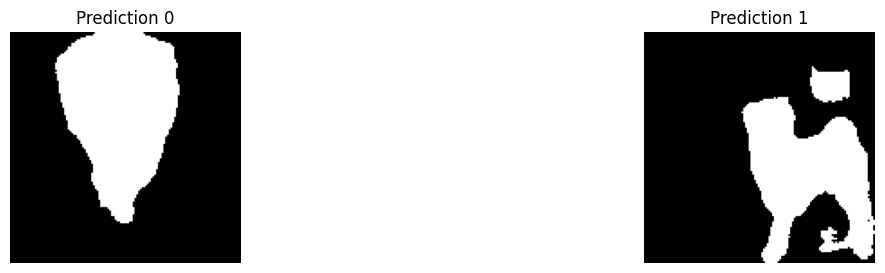

In [26]:
predictions= predictions.detach().cpu()
mymasks = predictions[:2]
mymasks = mymasks.squeeze(1)
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for i in range(2):
    axes[i].imshow(mymasks[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Prediction {i}')

plt.show()





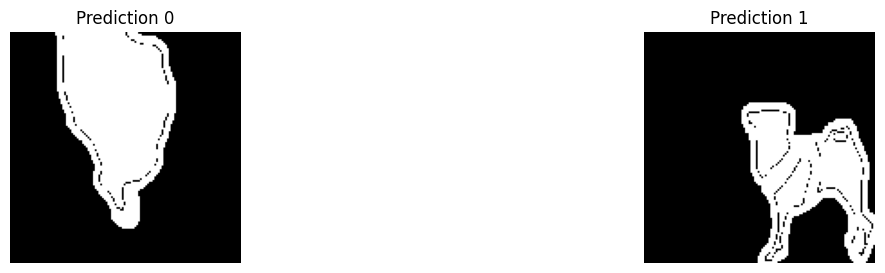

In [27]:
batch_y= batch_y.detach().cpu()
mymasks = batch_y[:2]
mymasks = mymasks.squeeze(1)
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for i in range(2):
    axes[i].imshow(mymasks[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Prediction {i}')

plt.show()





## Congratz, you made it! :)